# Basketball Hale of Fame prediction by implementing Logistic Regression

In this project the characteristics of the basketball players and their playing information are provided. Based on the characteristics, the target variable that is the player deservance to be in Hale of Fame will be predicted by implementing Logistic Regression model. The reason of choosing the model is that the target variable is binary (0 or 1), and Logistic Regression perfoms usually well for this situation

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
from matplotlib.pyplot import pie, axis, show

In [2]:
data=pd.read_csv('basketball_hall_of_fame_df (1).csv', sep=';')

In [3]:
data.shape

(2366, 19)

In [4]:
#finding categorical columns
categorical_features = (data.select_dtypes(include=['object']).columns.values)
categorical_features

array(['playerID', 'pos', 'college', 'birthDate', 'birthState',
       'birthCountry', 'ethnicity'], dtype=object)

In [5]:
#finding numerical columns
numerical_features = data.select_dtypes(include = ['float64', 'int64']).columns.values
numerical_features

array(['Unnamed: 0', 'stint', 'minutes', 'rebounds', 'assists', 'steals',
       'blocks', 'turnovers', 'careerDuration', 'height', 'weight',
       'target'], dtype=object)

Data cleaning and preprocessing

In [6]:
#finding the sum of null values in each columns
data.isnull().sum()

Unnamed: 0          0
playerID            0
stint               0
minutes             0
rebounds            0
assists             0
steals              0
blocks              0
turnovers           0
careerDuration      0
pos                 3
height              0
weight              0
college             0
birthDate           0
birthState        234
birthCountry       63
ethnicity           0
target              0
dtype: int64

Some variables are dropped out from the columns of the dataset. Unnamed, playerID, and college variables are useless for analysing, and there are many null values in birthCountry and birthState.

In [7]:
#removing columns
data=data.drop(['Unnamed: 0', 'playerID', 'college', 'birthCountry','birthState'], axis=1)

In [8]:
#finding null data in rows and dropping them out
null_data = data[data.isnull().any(axis=1)]
null_data

,stint,minutes,rebounds,assists,steals,blocks,turnovers,careerDuration,pos,height,weight,birthDate,ethnicity,target
270,1.25,638.50,103.25,29.75,22.25,8.00,27.25,4,NaN,79.0,225.0,1987-09-07,B,0.0
362,1.00,1959.75,170.00,262.00,106.00,9.50,130.25,4,NaN,73.0,190.0,1986-05-19,B,0.0
896,1.00,1282.33,162.33,80.00,36.33,20.33,59.33,3,NaN,77.0,215.0,1987-12-09,B,0.0


In [9]:
data= data.drop([270,362,896])

In [10]:
data.isnull().sum()

stint             0
minutes           0
rebounds          0
assists           0
steals            0
blocks            0
turnovers         0
careerDuration    0
pos               0
height            0
weight            0
birthDate         0
ethnicity         0
target            0
dtype: int64

In [11]:
null_birthdate = data[data['birthDate']=='0000-00-00']
null_birthdate

,stint,minutes,rebounds,assists,steals,blocks,turnovers,careerDuration,pos,height,weight,birthDate,ethnicity,target
149,3.00,720.0,110.00,49.00,0.0,0.0,0.0,3,F,75.0,195.0,0000-00-00,W,0.0
861,0.00,1321.0,0.00,0.00,0.0,0.0,0.0,4,F-G,75.0,195.0,0000-00-00,W,0.0
1375,0.50,1341.5,224.50,50.00,0.0,0.0,0.0,3,F-C,76.0,195.0,0000-00-00,B,0.0
1974,0.33,1316.0,299.67,40.33,0.0,0.0,27.0,3,F,77.0,188.0,0000-00-00,B,0.0


In [12]:
data= data.drop([149,861,1375,1974])

In [13]:
#The birthDate column that is demonestrated with year-month-date, is changed to year and integer in order to be interpretable.
data["birthDate"] = pd.to_datetime(data['birthDate'])
data["birthDate"] = pd.to_datetime(data["birthDate"]).dt.strftime('%Y')

In [14]:
data["birthDate"]=data.birthDate.astype('int')

In [15]:
#changing categorical to dummy value
dummy_ranks = pd.get_dummies(data['pos'], prefix = 'pos')
dummy_ranks1=pd.get_dummies(data['ethnicity'], prefix='ethnicity')
#joining dummy variables to the dataset
cols_to_keep=['target','stint','minutes','rebounds','assists','steals','blocks','turnovers','careerDuration','height','weight','birthDate']
data = data[cols_to_keep].join(dummy_ranks[['pos_C','pos_C-F','pos_F', 'pos_F-C','pos_F-G','pos_G','pos_G-F']])
cols_to_keep1=['target','stint','minutes','rebounds','assists','steals','blocks','turnovers','careerDuration','height','weight','birthDate','pos_C','pos_C-F','pos_F', 'pos_F-C','pos_F-G','pos_G','pos_G-F']
data = data[cols_to_keep1].join(dummy_ranks1[['ethnicity_B','ethnicity_W','ethnicity_O']])
data.head()

,target,stint,minutes,rebounds,assists,steals,blocks,turnovers,careerDuration,height,...,pos_C,pos_C-F,pos_F,pos_F-C,pos_F-G,pos_G,pos_G-F,ethnicity_B,ethnicity_W,ethnicity_O
0,0.0,1.29,457.14,120.86,12.14,10.14,10.00,35.29,7,82.0,...,0,0,0,1,0,0,0,1,0,0
1,1.0,1.00,2872.30,872.00,283.00,58.00,159.45,126.35,20,85.0,...,1,0,0,0,0,0,0,1,0,0
2,0.0,1.09,1745.64,195.09,323.18,2.36,0.55,0.00,11,74.0,...,0,0,0,0,0,1,0,1,0,0
3,0.0,1.00,1736.44,120.78,231.00,54.11,5.11,107.00,9,73.0,...,0,0,0,0,0,1,0,1,0,0
4,0.0,1.14,683.29,110.00,37.71,26.00,11.71,43.71,8,78.0,...,0,0,0,0,0,0,1,1,0,0


In [16]:
data.describe()

,target,stint,minutes,rebounds,assists,steals,blocks,turnovers,careerDuration,height,...,pos_C,pos_C-F,pos_F,pos_F-C,pos_F-G,pos_G,pos_G-F,ethnicity_B,ethnicity_W,ethnicity_O
count,2359.000000,2359.000000,2359.000000,2359.000000,2359.000000,2359.000000,2359.000000,2359.000000,2359.000000,2359.000000,...,2359.000000,2359.000000,2359.000000,2359.000000,2359.000000,2359.000000,2359.000000,2359.000000,2359.000000,2359.000000
mean,0.100042,1.111276,1142.902628,213.718084,105.772569,28.770441,17.195019,55.157745,8.272149,78.314964,...,0.097075,0.064858,0.239932,0.125053,0.063586,0.311149,0.098347,0.660449,0.337007,0.002543
std,0.300120,0.186484,684.934223,178.049844,103.780251,29.301132,26.282693,51.473312,4.240205,3.556224,...,0.296123,0.246327,0.427132,0.330849,0.244066,0.463062,0.297846,0.473657,0.472788,0.050379
min,0.000000,0.000000,6.750000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,63.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,579.500000,85.365000,33.000000,4.815000,1.410000,11.085000,5.000000,76.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.070000,1088.170000,171.250000,73.460000,21.220000,7.600000,44.000000,8.000000,79.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.185000,1650.040000,291.560000,143.740000,44.320000,21.000000,85.420000,11.000000,81.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,3.000000,3190.600000,1663.080000,831.890000,193.000000,278.550000,283.230000,24.000000,91.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Target values are counted and plotted.

In [17]:
data['target'].value_counts()

0.0    2123
1.0     236
Name: target, dtype: int64

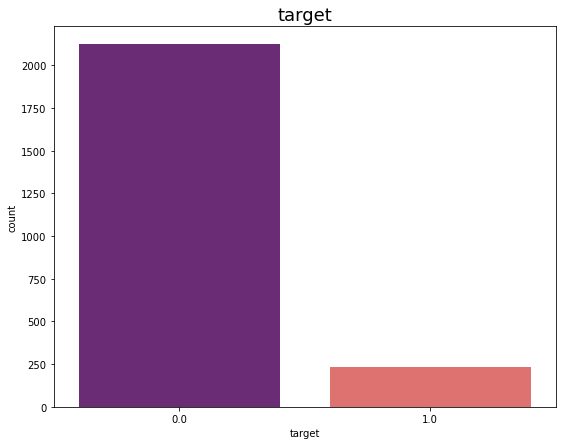

In [18]:
plt.figure(figsize=(9,7))
ax=sns.countplot(x='target', data=data, palette='magma')
ax.set_title('target',fontsize=18)
ax.set_ylabel('count')
ax.set_xlabel("target")
plt.show()

The corrolation plot is demonestrated below to show the relationship of each pairs of variables and their strength of that relationship. According to this plot, we can realize that the duration of players being in game and players in games assists have moderately positive correlation with target value. It means that the more time players being in games and players assists, the more they would be deserve to be in Hall of Fame.

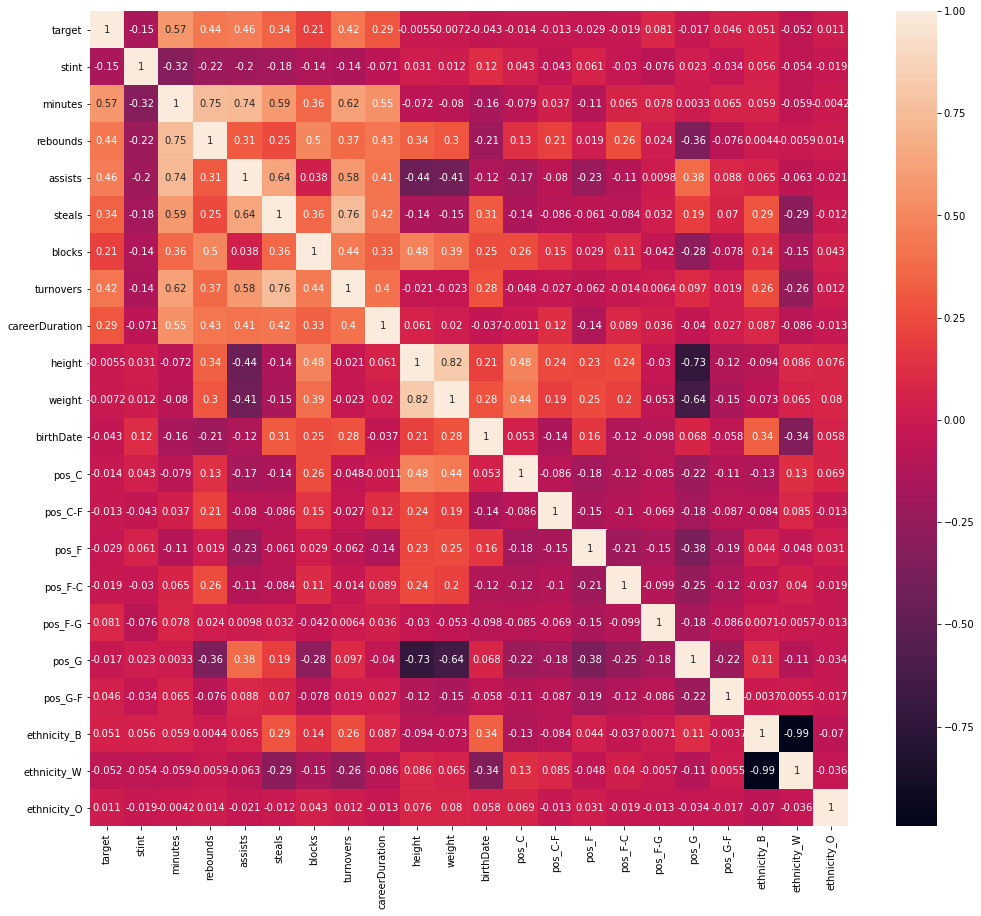

In [19]:
# checking correlation using heatmap
plt.figure(figsize=(17,15))
ax = sns.heatmap(data.corr(), annot=True)

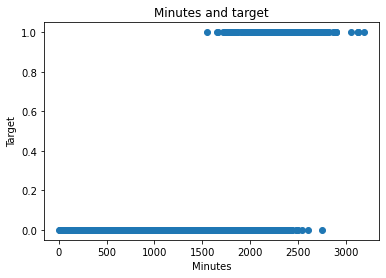

In [20]:
plt.scatter(data['minutes'],data['target'])
plt.title('Minutes and target')
plt.xlabel('Minutes')
plt.ylabel('Target')
plt.show()

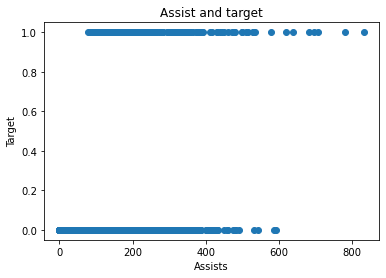

In [21]:
plt.scatter(data['assists'],data['target'])
plt.title('Assist and target')
plt.xlabel('Assists')
plt.ylabel('Target')
plt.show()

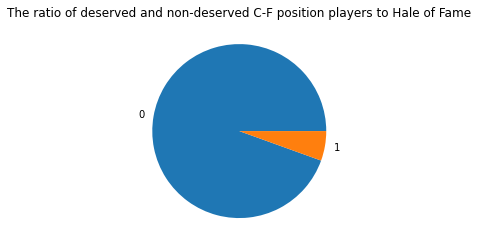

In [22]:
plt.subplot(title='The ratio of deserved and non-deserved C-F position players to Hale of Fame')
sums = data.target.groupby(data['pos_C-F']).sum()
axis('equal');
pie(sums, labels=sums.index);
show()

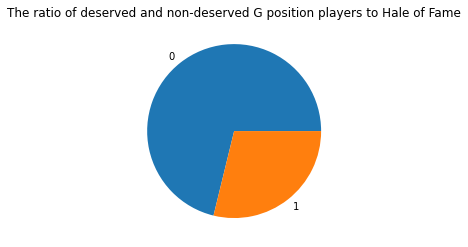

In [23]:
plt.subplot(title='The ratio of deserved and non-deserved G position players to Hale of Fame')
sums = data.target.groupby(data['pos_G']).sum()
axis('equal');
pie(sums, labels=sums.index);
show()

In [24]:
data.loc[(data['pos_G']==1) & (data['target']==1)].shape

(68, 22)

In [25]:
data.loc[(data['pos_C-F']==1) & (data['target']==1)].shape

(13, 22)

In [26]:
print("The ration of G position players enterd Hale of Fame to all of the players entered Hale of Fame = ",(68/236)*100)
print("The ratio of C-F position players entered Hale of Fame to all of the players entered Hale of Fame = ",(13/236)*100)

The ration of G position players enterd Hale of Fame to all of the players entered Hale of Fame =  28.8135593220339
The ratio of C-F position players entered Hale of Fame to all of the players entered Hale of Fame =  5.508474576271186


According to the pie charts, players in position G and players in position C-F have the most and the least ratio of entered players to the Fame of Hall, respectively. About 29 percent of the players of G position and 5 percent of C-F position among all of the Hale of Fame deserved players entered Hale of Fame.

C:\Users\farna\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='height', ylabel='Density'>

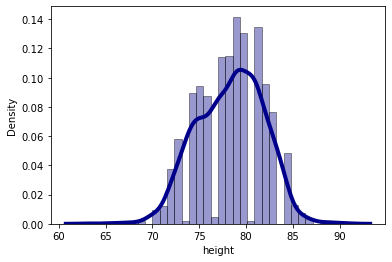

In [27]:
sns.distplot(data['height'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

The height of the most of the players is in the range (76,78)

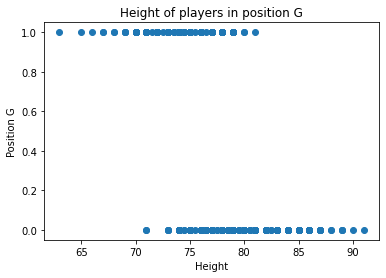

In [28]:
plt.scatter(data['height'],data['pos_G'])
plt.title('Height of players in position G')
plt.xlabel('Height')
plt.ylabel('Position G')
plt.show()

It is surprising that players in position G (the most ratio of deserve players for Hale of Fame) are not among the tallest players. Also there is a significant negative correlation between the two variables (-0.73)

In [29]:
aaa=data.loc[(data['target']==1)]
aaa['height'].mean()

78.25635593220339

The mean height of the deserve players for Hale of Fame is almost equal to the mean height of the totall players.

Our dataset is spilitted into training and testing.

In [55]:
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
x_train,x_test,y_train,y_test=train_test_split(data.drop('target', axis=1), data['target'], test_size=0.2)
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=21, scoring='accuracy')
rfecv.fit(x_train, y_train)

C:\Users\farna\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\farna\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

RFECV(cv=21, estimator=LogisticRegression(), scoring='accuracy')

In [56]:
print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % (x_train.columns[rfecv.support_]))

Optimal number of features: 10
Selected features: Index(['minutes', 'assists', 'steals', 'blocks', 'turnovers', 'careerDuration',
       'height', 'birthDate', 'pos_F-C', 'pos_F-G'],
      dtype='object')


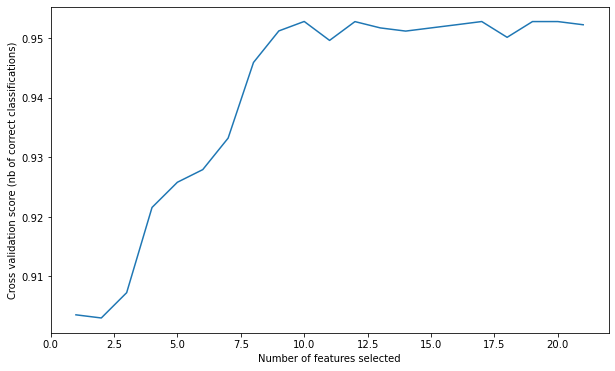

In [57]:
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [64]:
df=data.drop(['stint', 'rebounds','ethnicity_O','ethnicity_B','ethnicity_W', 'weight','pos_C', 'pos_C-F','pos_G','pos_G-F','pos_F'], axis=1)

In [65]:
x_train,x_test,y_train,y_test=train_test_split(df.drop('target', axis=1), df['target'], test_size=0.2)

In [66]:
LogReg=LogisticRegression(solver='lbfgs')
LogReg.fit(x_train, y_train)

C:\Users\farna\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [67]:
LogReg.score(x_test,y_test)

0.951271186440678

In [68]:
y_predict=LogReg.predict(x_test)

In [69]:
a= confusion_matrix(y_test,y_predict)
a

array([[413,  11],
       [ 12,  36]], dtype=int64)

Text(0.5, 1.0, 'Confusion Matrix')

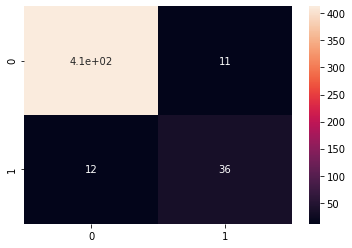

In [70]:
sns.heatmap(a, annot=True)
ax.set_title('Confusion Matrix',fontsize=18)

This study contains an analysis of basketball dataset and a prediction of players who is deserve to enter Fame of Hale based on characteristics of the players. The duration of players being in game and players in games assists with target value are two moderate correlations that have found in this study. Also players in position G and position C-F have the most and the least ratio of the players entered to Hale of Fame, respectively.
For prediction section, cross validation is implemented and the number of optimal variables for prediction of the target variable is considered. After spilitting of the dataset into test_set and train_set, the designed model presented %95 accuracy. Results are plotted in the report.
For future investigation it would be better if two more models implemented and the resuls of them be compared together.